# Milestone 2:  EDA and Baseline Pipeline on All Available Data

## Project notebook


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import os
import glob
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, lit, lead, lag, avg, stddev, min, max, concat_ws
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, DateType, IntegerType
from pyspark.sql.functions import sqrt, avg, lead, col, expr, to_date, year, mean, log, row_number
from pyspark.sql.window import Window

In [ ]:
# Initialize PySpark session
spark = SparkSession.builder \
    .appName("Stock Price Forecast") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

## 1. EDA

In [2]:


# Define paths to data directories
csv_path = "data/stock_market_data/forbes2000/csv/"
json_path = "data/stock_market_data/forbes2000/json/"

# Get a list of all available stock files
csv_files = glob.glob(os.path.join(csv_path, "*.csv"))
json_files = glob.glob(os.path.join(json_path, "*.json"))

print(f"Found {len(csv_files)} CSV files and {len(json_files)} JSON files")

# Display some sample stocks
print("Sample stocks:")
print([os.path.basename(file).split('.')[0] for file in csv_files[:10]])

25/03/30 14:37:30 WARN Utils: Your hostname, Xuhuis-MacBook-Pro-126.local resolves to a loopback address: 127.0.0.1; using 172.16.96.118 instead (on interface en0)
25/03/30 14:37:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/30 14:37:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Found 1076 CSV files and 1170 JSON files
Sample stocks:
['CSCO', 'CSUAY', 'MQBKY', 'AIPUY', 'ZURVY', 'PWCDF', 'SMTUF', 'BCMXY', 'JMPLY', 'KOTMY']


#### Raw Features and Derived Features

The rew features from the CSV dataset will be used directly for the future development:

- Date: Trading date

- Low: Lowest price of the day

- Open: Opening price

- Volume: Number of shares traded

- High: Highest price of the day

- Close: Closing price

- Adjusted Close: Closing price adjusted for splits and dividends

Some features from the JSON dataset:

- Meta data: Currency, symbol, exchange, instrument type, etc.

- Trading periods information

- More granular timestamp series

- Additional price history details

In [3]:
# Define schema for CSV files to ensure consistent data types
csv_schema = StructType([
    StructField("Date", StringType(), True),
    StructField("Low", DoubleType(), True),
    StructField("Open", DoubleType(), True),
    StructField("Volume", IntegerType(), True),
    StructField("High", DoubleType(), True),
    StructField("Close", DoubleType(), True),
    StructField("Adjusted_Close", DoubleType(), True)
])

# Create an empty DataFrame to store the combined CSV data
combined_df = None

# Process a sample of CSV files (e.g., first 20 files) for initial exploration
for file in csv_files[:20]:
    ticker = os.path.basename(file).split('.')[0]
    
    # Read the CSV file into a Spark DataFrame
    current_df = spark.read.csv(file, header=True, schema=csv_schema)
    
    # Add ticker symbol as a column
    current_df = current_df.withColumn("Symbol", lit(ticker))
    
    # Convert date string to date type
    current_df = current_df.withColumn("Date", to_date(col("Date"), "dd-MM-yyyy"))
    
    # Append to the combined DataFrame
    if combined_df is None:
        combined_df = current_df
    else:
        combined_df = combined_df.union(current_df)

# Show summary of the combined data
print(f"Combined CSV data contains {combined_df.count()} rows for {len(combined_df.select('Symbol').distinct().collect())} stocks")
combined_df.printSchema()
combined_df.show(5)

# Analyze JSON structure from one file to understand available fields
sample_json_file = json_files[0]
with open(sample_json_file, 'r') as f:
    sample_json = json.load(f)

# Extract metadata fields from JSON
meta = sample_json['chart']['result'][0]['meta']
print("\nJSON Metadata Fields:")
for key, value in meta.items():
    if not isinstance(value, dict):
        print(f"- {key}: {value}")

# Look at available indicator types in JSON
indicators = sample_json['chart']['result'][0]['indicators']
print("\nAvailable indicators in JSON:")
for indicator_type, values in indicators.items():
    print(f"- {indicator_type}: {len(values[0]) if len(values) > 0 else 0} fields")

Combined CSV data contains 79969 rows for 20 stocks
root
 |-- Date: date (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- High: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adjusted_Close: double (nullable = true)
 |-- Symbol: string (nullable = false)



25/03/30 14:41:13 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Date, Low, Open, Volume, High, Close, Adjusted Close
 Schema: Date, Low, Open, Volume, High, Close, Adjusted_Close
Expected: Adjusted_Close but found: Adjusted Close
CSV file: file:///Users/xuhuizhan/homework/BigData/Final_project/data/stock_market_data/forbes2000/csv/CSCO.csv


+----------+-------------------+----+---------+-------------------+-------------------+-------------------+------+
|      Date|                Low|Open|   Volume|               High|              Close|     Adjusted_Close|Symbol|
+----------+-------------------+----+---------+-------------------+-------------------+-------------------+------+
|1990-02-16|0.07378499954938889| 0.0|940636800|0.07986100018024445|0.07725699990987778|0.05486249923706055|  CSCO|
|1990-02-20|0.07465299963951111| 0.0|151862400|0.07986100018024445|0.07986100018024445|0.05671168491244316|  CSCO|
|1990-02-21|0.07552099972963333| 0.0| 70531200|0.07899300009012222|           0.078125|0.05547890439629555|  CSCO|
|1990-02-22|0.07899300009012222| 0.0| 45216000|0.08159700036048889|0.07899300009012222|0.05609529837965965|  CSCO|
|1990-02-23|           0.078125| 0.0| 44697600|0.07986100018024445|0.07855899631977081|0.05578707531094551|  CSCO|
+----------+-------------------+----+---------+-------------------+-------------

#### Basic Visialization of Raw features for CSV files and JSON files

For the CSV files:

25/03/16 11:18:37 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Date, Low, Open, Volume, High, Close, Adjusted Close
 Schema: Date, Low, Open, Volume, High, Close, Adjusted_Close
Expected: Adjusted_Close but found: Adjusted Close
CSV file: file:///Users/xuhuizhan/homework/BigData/Final_project/data/stock_market_data/forbes2000/csv/CSCO.csv
25/03/16 11:18:37 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Date, Low, Open, Volume, High, Close, Adjusted Close
 Schema: Date, Low, Open, Volume, High, Close, Adjusted_Close
Expected: Adjusted_Close but found: Adjusted Close
CSV file: file:///Users/xuhuizhan/homework/BigData/Final_project/data/stock_market_data/forbes2000/csv/CSUAY.csv


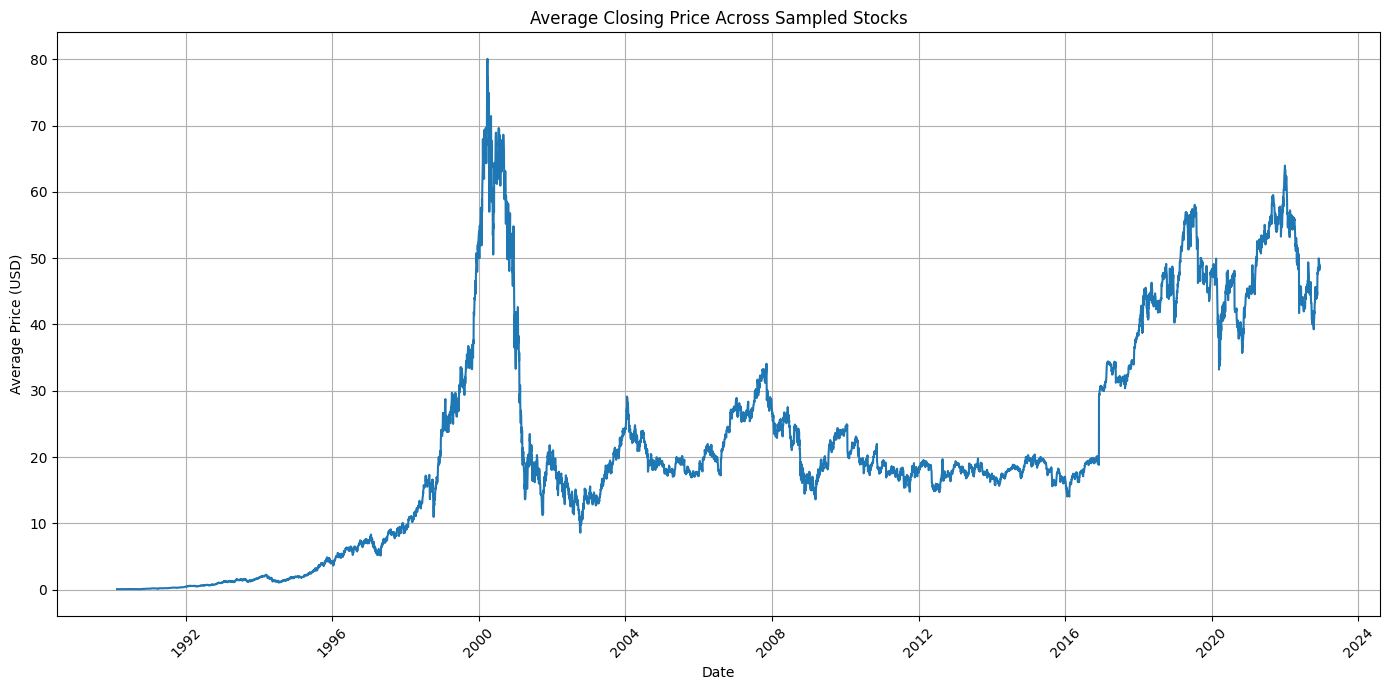

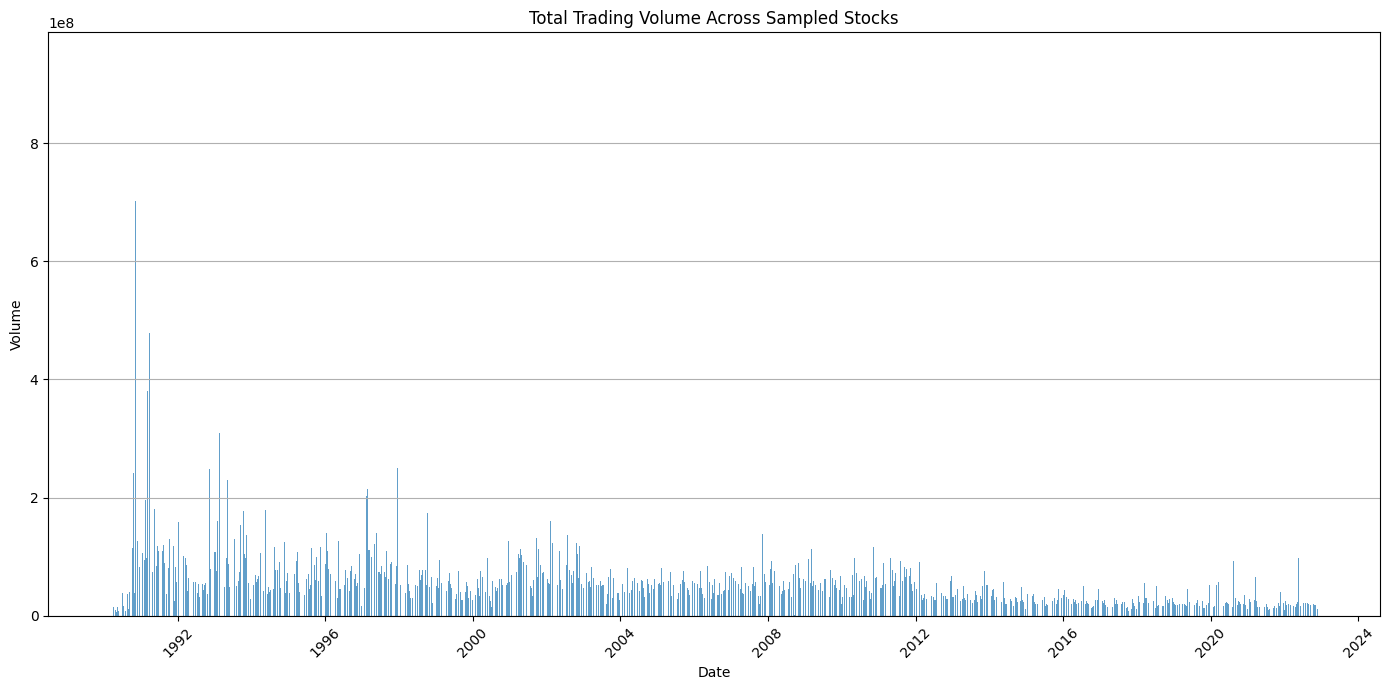

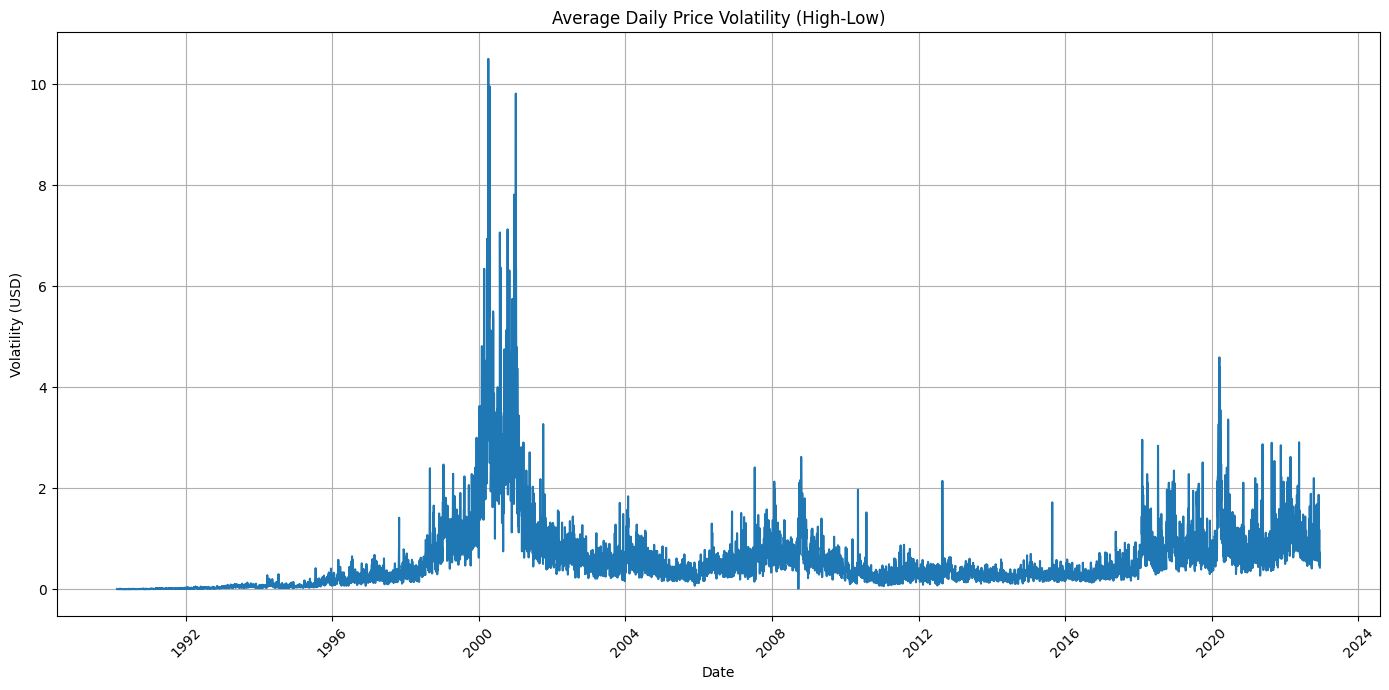

In [4]:
# Convert to Pandas for visualization (use a sample for efficiency)
pandas_df = combined_df.limit(10000).toPandas()

# Group by date and calculate market-wide metrics
market_df = pandas_df.groupby('Date').agg({
    'Close': 'mean',
    'Volume': 'sum',
    'High': 'mean',
    'Low': 'mean'
}).reset_index()

# Plot market-wide closing price trend
plt.figure(figsize=(14, 7))
plt.plot(market_df['Date'], market_df['Close'])
plt.title('Average Closing Price Across Sampled Stocks')
plt.xlabel('Date')
plt.ylabel('Average Price (USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot trading volume trend
plt.figure(figsize=(14, 7))
plt.bar(market_df['Date'], market_df['Volume'], alpha=0.7)
plt.title('Total Trading Volume Across Sampled Stocks')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize price volatility over time
market_df['Volatility'] = market_df['High'] - market_df['Low']
plt.figure(figsize=(14, 7))
plt.plot(market_df['Date'], market_df['Volatility'])
plt.title('Average Daily Price Volatility (High-Low)')
plt.xlabel('Date')
plt.ylabel('Volatility (USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import shutil
print(shutil.which("xelatex"))


C:\Users\10648\AppData\Local\Programs\MiKTeX\miktex\bin\x64\xelatex.EXE


Some derived features that we plan to use in the future model training and development:

**Average Return**  :

This is the average of the daily returns for each stock. Daily return is calculated as the percentage change from the previous day's close:

$ \mathrm{DailyReturn} = \dfrac{\mathrm{Close} - \mathrm{PrevClose}}{\mathrm{PrevClose}} $



Taking the mean of these daily returns over a period gives a rough sense of how much, on average, the stock's value changes from day to day. A higher average return may indicate stronger performance.

---

**Volatility**  
Volatility here is measured as the standard deviation of the daily returns. This tells you how much the stock’s returns vary from the mean on a day-to-day basis. A higher volatility means larger up or down swings in the stock’s daily return, while a lower volatility suggests more stable returns.

---

**Trading Days**  
This is the count of the number of trading days (i.e., the number of rows) for each stock in the dataset. Filtering for stocks with more than 500 trading days ensures that there is sufficient historical data to provide reliable statistics for average return and volatility.

In [4]:
# Calculate returns for each stock
window_spec = Window.partitionBy("Symbol").orderBy("Date")
combined_df = combined_df.withColumn("PrevClose", lag("Close", 1).over(window_spec))
combined_df = combined_df.withColumn("DailyReturn", (col("Close") - col("PrevClose")) / col("PrevClose"))

# Summary statistics of returns by stock
returns_by_stock = combined_df.groupBy("Symbol").agg(
    avg(col("DailyReturn")).alias("AvgReturn"),
    stddev(col("DailyReturn")).alias("Volatility"),
    count("*").alias("TradingDays")
)

# Filter for stocks with sufficient data
active_stocks = returns_by_stock.filter(col("TradingDays") > 500)

# Show top stocks by average return
print("Top 10 Stocks by Average Return:")
active_stocks.orderBy(col("AvgReturn").desc()).show(10)

# Show top stocks by volatility
print("Top 10 Stocks by Volatility:")
active_stocks.orderBy(col("Volatility").desc()).show(10)

Top 10 Stocks by Average Return:


+------+--------------------+--------------------+-----------+
|Symbol|           AvgReturn|          Volatility|TradingDays|
+------+--------------------+--------------------+-----------+
|  AUTR|0.004226934351660896| 0.12415432977666538|       2994|
| AIPUY|0.001395491989984...|0.036751769256370824|       2555|
|  ISRG|0.001356723705433...|0.031622103192064835|       5659|
|  CSCO|0.001101145212940...| 0.02539036285241598|       8269|
|   UAL|9.208234591147626E-4| 0.04181226274169283|       4243|
|  TROW| 8.23801362467354E-4|0.023837998444357102|       9251|
| SZLMY|7.389298917427634E-4|0.019834647211186798|       3422|
|  PBNK|6.140578505195129E-4| 0.03165189097679212|       3934|
| MQBKY|5.961209532660768E-4|0.028106562247908983|       4129|
| ZURVY|4.545994492009156E-4|0.018491849351474646|       4916|
+------+--------------------+--------------------+-----------+
only showing top 10 rows

Top 10 Stocks by Volatility:
+------+--------------------+--------------------+-----------+


Correlation Matrix:
                 Open      High       Low     Close    Volume  DailyReturn
Open         1.000000  0.999005  0.999025  0.998558 -0.105543     0.012700
High         0.999005  1.000000  0.998151  0.999025 -0.105560     0.018450
Low          0.999025  0.998151  1.000000  0.999006 -0.106006     0.020327
Close        0.998558  0.999025  0.999006  1.000000 -0.105745     0.031201
Volume      -0.105543 -0.105560 -0.106006 -0.105745  1.000000    -0.016620
DailyReturn  0.012700  0.018450  0.020327  0.031201 -0.016620     1.000000


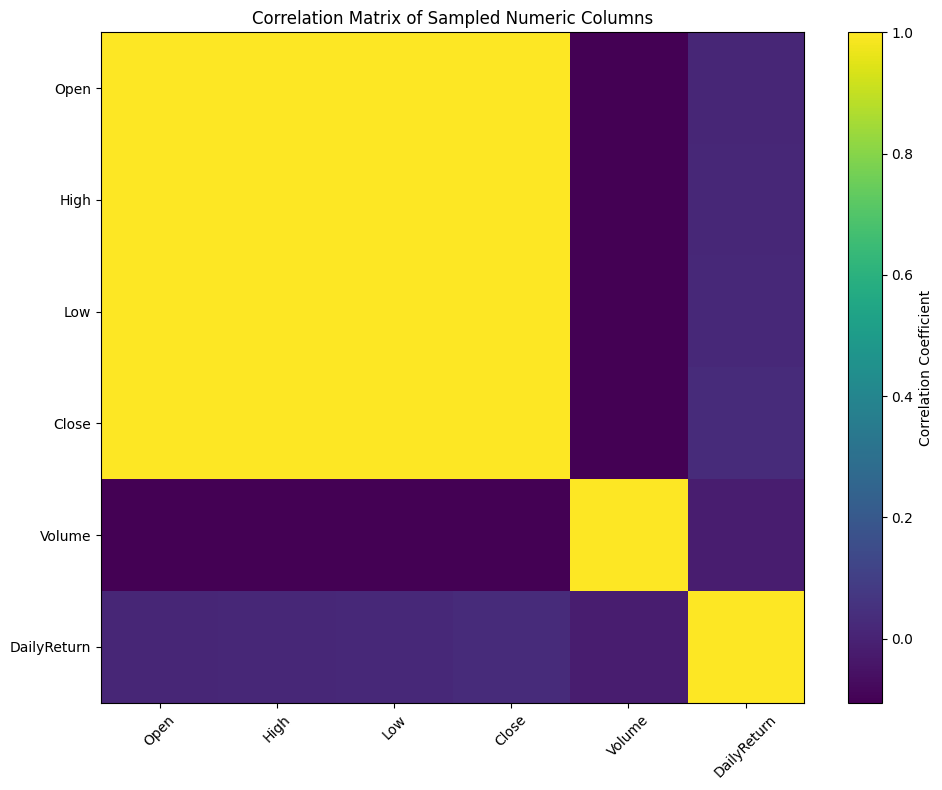

In [5]:
# Correlation analysis of numeric columns

numeric_cols = ["Open", "High", "Low", "Close", "Volume", "DailyReturn"]

# Limit the dataset to a manageable size for Pandas
sample_df = combined_df.select(*numeric_cols).limit(5000).toPandas()

# Drop any rows with nulls in those columns to avoid NaN correlation issues
sample_df = sample_df.dropna(subset=numeric_cols)

# Compute the correlation matrix
corr_matrix = sample_df.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(corr_matrix)

# Plot the correlation matrix as a heatmap
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title('Correlation Matrix of Sampled Numeric Columns')
plt.tight_layout()
plt.show()


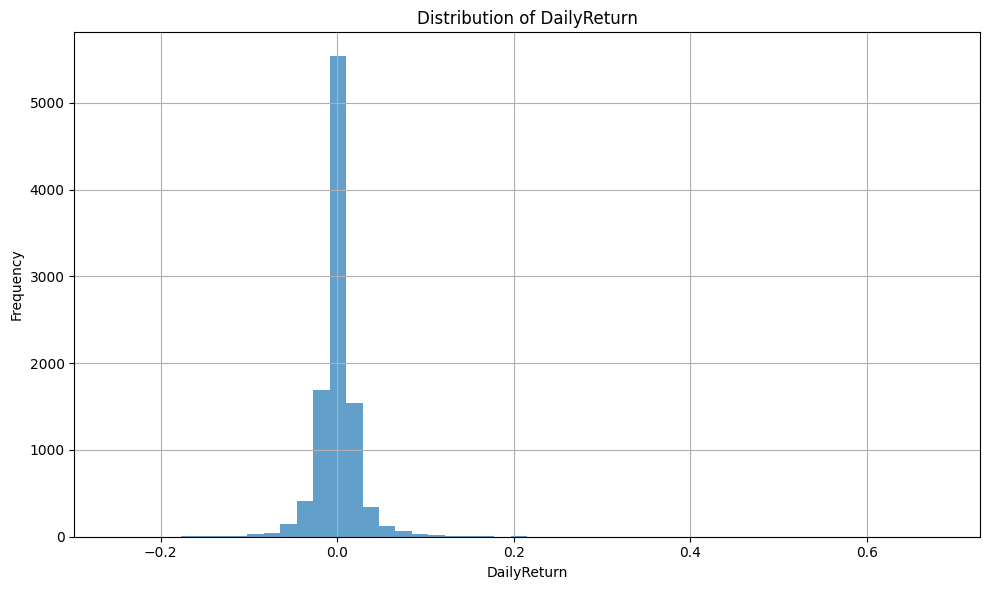

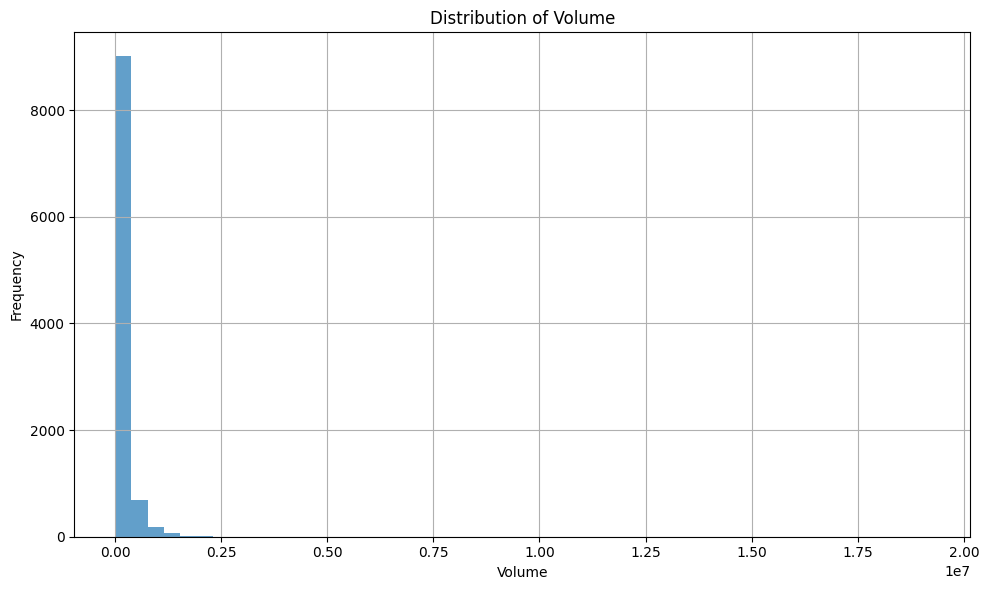

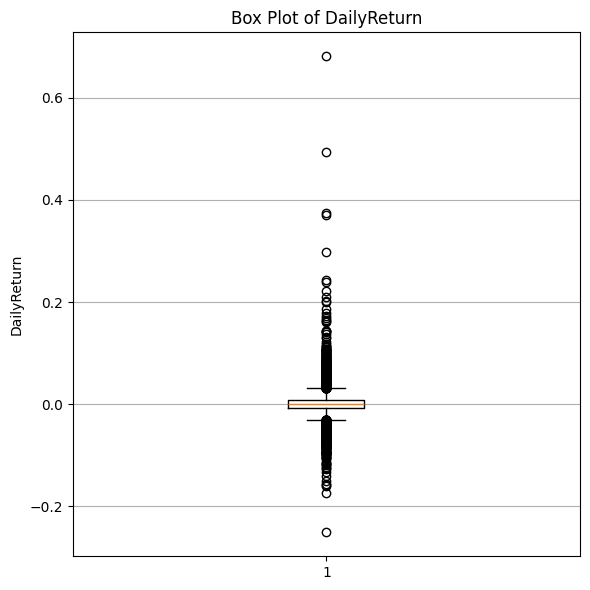

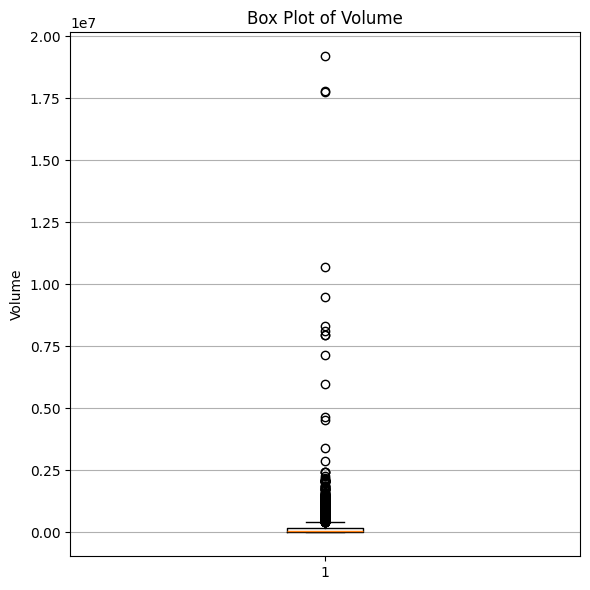

In [6]:
# Distribution analysis of DailyReturn and Volume

dist_cols = ["DailyReturn", "Volume"]
dist_sample_df = combined_df.select(*dist_cols).limit(10000).toPandas()

# Drop nulls for clarity
dist_sample_df = dist_sample_df.dropna(subset=dist_cols)

# Plot histograms
for col_name in dist_cols:
    plt.figure(figsize=(10, 6))
    plt.hist(dist_sample_df[col_name], bins=50, alpha=0.7)
    plt.title(f'Distribution of {col_name}')
    plt.xlabel(col_name)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
# Plot boxplots
for col_name in dist_cols:
    plt.figure(figsize=(6, 6))
    plt.boxplot(dist_sample_df[col_name], vert=True)
    plt.title(f'Box Plot of {col_name}')
    plt.ylabel(col_name)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


In [6]:
# Function to detect outliers using IQR method
def detect_outliers(df, column_name):
    # Calculate quartiles for each stock
    quartiles = df.groupBy("Symbol").agg(
        expr(f"percentile({column_name}, 0.25)").alias("Q1"),
        expr(f"percentile({column_name}, 0.75)").alias("Q3")
    )
    
    # Calculate IQR and bounds
    quartiles = quartiles.withColumn("IQR", col("Q3") - col("Q1"))
    quartiles = quartiles.withColumn("LowerBound", col("Q1") - 1.5 * col("IQR"))
    quartiles = quartiles.withColumn("UpperBound", col("Q3") + 1.5 * col("IQR"))
    
    # Join back to main dataframe
    df_with_bounds = df.join(quartiles.select("Symbol", "LowerBound", "UpperBound"), "Symbol")
    
    # Flag outliers
    outliers = df_with_bounds.filter(
        (col(column_name) < col("LowerBound")) | 
        (col(column_name) > col("UpperBound"))
    )
    
    return outliers

# Detect outliers in volume
volume_outliers = detect_outliers(combined_df, "Volume")
print(f"Volume outliers: {volume_outliers.count()} ({volume_outliers.count()/combined_df.count()*100:.2f}%)")

# Detect outliers in daily returns
return_outliers = detect_outliers(combined_df.filter(col("DailyReturn").isNotNull()), "DailyReturn")
print(f"Return outliers: {return_outliers.count()} ({return_outliers.count()/combined_df.filter(col('DailyReturn').isNotNull()).count()*100:.2f}%)")

# Sample some outliers to understand their nature
print("Sample volume outliers:")
volume_outliers.select("Symbol", "Date", "Volume", "LowerBound", "UpperBound").show(10)

print("Sample return outliers:")
return_outliers.select("Symbol", "Date", "DailyReturn", "LowerBound", "UpperBound").show(10)

Volume outliers: 7554 (9.45%)


Return outliers: 8413 (10.55%)
Sample volume outliers:
+------+----------+---------+-----------+-----------+
|Symbol|      Date|   Volume| LowerBound| UpperBound|
+------+----------+---------+-----------+-----------+
|  CSCO|2014-02-13|153739400|-2.880675E7|1.2281445E8|
|  CSCO|2013-11-14|243255400|-2.880675E7|1.2281445E8|
|  CSCO|2013-08-15|130110100|-2.880675E7|1.2281445E8|
|  CSCO|2013-05-16|201626500|-2.880675E7|1.2281445E8|
|  CSCO|2012-08-16|152184100|-2.880675E7|1.2281445E8|
|  CSCO|2012-05-10|198450600|-2.880675E7|1.2281445E8|
|  CSCO|2012-02-09|131157200|-2.880675E7|1.2281445E8|
|  CSCO|2011-11-10|148101900|-2.880675E7|1.2281445E8|
|  CSCO|2011-08-11|286920000|-2.880675E7|1.2281445E8|
|  CSCO|2011-08-10|146477100|-2.880675E7|1.2281445E8|
+------+----------+---------+-----------+-----------+
only showing top 10 rows

Sample return outliers:
+------+----------+--------------------+----------+----------+
|Symbol|      Date|         DailyReturn|LowerBound|UpperBound|
+------+-----

For the JSON files:

In [10]:
# Path to JSON files
json_path = "data/stock_market_data/forbes2000/json/"
json_files = glob.glob(os.path.join(json_path, "*.json"))

# Sample a few JSON files to understand their structure
sample_json_files = json_files[:5]
json_structures = []

for file in sample_json_files:
    ticker = os.path.basename(file).split('.')[0]
    with open(file, 'r') as f:
        data = json.load(f)
    
    # Extract metadata
    try:
        meta = data['chart']['result'][0]['meta']
        indicators = data['chart']['result'][0]['indicators']
        timestamps = data['chart']['result'][0]['timestamp']
        
        # Count available data points
        quote_length = len(indicators['quote'][0]['close']) if 'quote' in indicators else 0
        
        # Extract available indicator types
        available_indicators = list(indicators.keys())
        
        json_structures.append({
            'Symbol': ticker,
            'MetadataFields': list(meta.keys()),
            'AvailableIndicators': available_indicators,
            'TimeseriesLength': len(timestamps),
            'QuoteDataPoints': quote_length
        })
    except (KeyError, IndexError) as e:
        print(f"Error analyzing {file}: {e}")

# Convert to DataFrame for analysis
json_structure_df = pd.DataFrame(json_structures)
print("JSON Structure Analysis:")
print(json_structure_df)

# Analyze metadata fields across files
all_metadata_fields = set()
for fields in json_structure_df['MetadataFields']:
    all_metadata_fields.update(fields)
    
print(f"\nCommon metadata fields across JSON files: {all_metadata_fields}")

# Analyze indicator types across files
all_indicators = set()
for indicators in json_structure_df['AvailableIndicators']:
    all_indicators.update(indicators)
    
print(f"\nAvailable indicator types in JSON files: {all_indicators}")

JSON Structure Analysis:
  Symbol                                     MetadataFields  \
0  FOJCY  [currency, symbol, exchangeName, instrumentTyp...   
1      T  [currency, symbol, exchangeName, instrumentTyp...   
2    PHM  [currency, symbol, exchangeName, instrumentTyp...   
3    ADM  [currency, symbol, exchangeName, instrumentTyp...   
4    RNA  [currency, symbol, exchangeName, instrumentTyp...   

  AvailableIndicators  TimeseriesLength  QuoteDataPoints  
0   [quote, adjclose]              3259             3259  
1   [quote, adjclose]              9846             9846  
2   [quote, adjclose]             10778            10778  
3   [quote, adjclose]             10778            10778  
4   [quote, adjclose]               631              631  

Common metadata fields across JSON files: {'chartPreviousClose', 'instrumentType', 'currency', 'firstTradeDate', 'timezone', 'currentTradingPeriod', 'symbol', 'dataGranularity', 'regularMarketPrice', 'validRanges', 'regularMarketTime', 'exch

Basic statistics for JSON price data:
               Open          High           Low         Close        Volume  \
count  35292.000000  35292.000000  35292.000000  35292.000000  3.529200e+04   
mean      17.153682     17.488223     17.052797     17.273139  7.336812e+06   
std       14.784774     14.825064     14.475348     14.652317  1.410614e+07   
min        0.000000      0.156250      0.140625      0.144531  0.000000e+00   
25%        4.580000      4.625000      4.545612      4.590000  7.729452e+05   
50%       13.804985     13.991539     13.613767     13.809649  2.266462e+06   
75%       26.230000     26.480000     25.915422     26.211502  5.819225e+06   
max       98.709999     98.879997     96.849998     98.220001  3.270974e+08   

           AdjClose  
count  35292.000000  
mean      11.722431  
std       13.449199  
min        0.102742  
25%        2.314733  
50%        6.739854  
75%       17.583542  
max       97.669998  

JSON data density (non-null values):
Symbol      1.

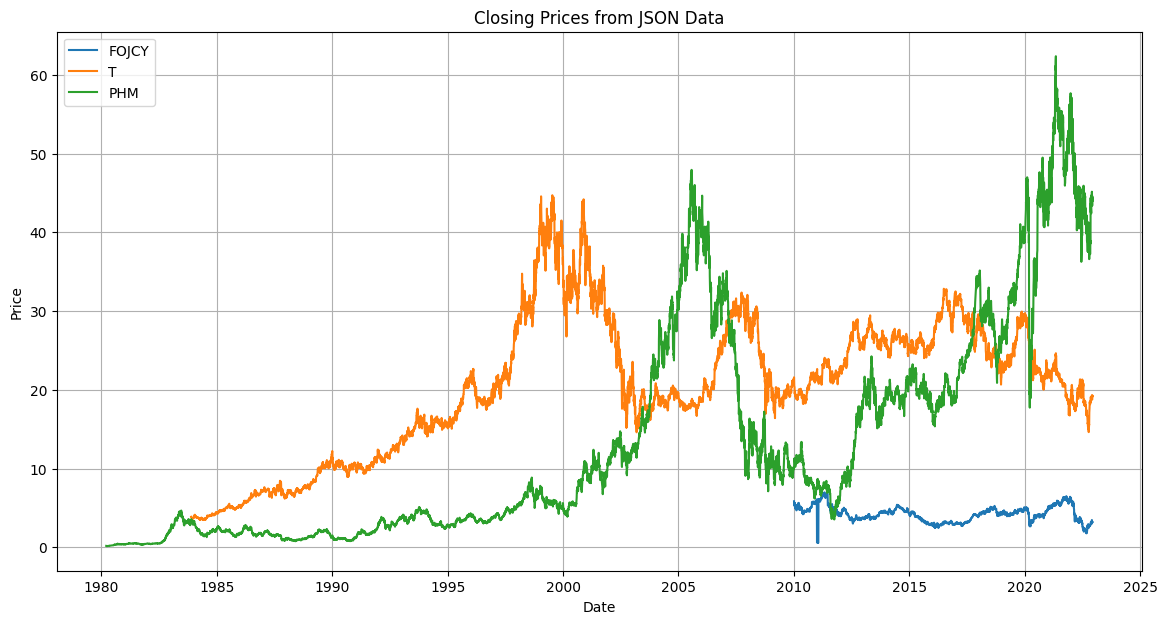

In [11]:
def extract_json_price_data(json_file):
    """Extract detailed price data from JSON file"""
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    try:
        ticker = os.path.basename(json_file).split('.')[0]
        result = data['chart']['result'][0]
        meta = result['meta']
        timestamps = result['timestamp']
        
        # Convert timestamps to dates
        dates = [datetime.fromtimestamp(ts).strftime('%Y-%m-%d') for ts in timestamps]
        
        # Extract quote data
        quotes = result['indicators']['quote'][0]
        
        # Create DataFrame with detailed price data
        df = pd.DataFrame({
            'Symbol': ticker,
            'Date': dates,
            'Open': quotes.get('open', [None] * len(dates)),
            'High': quotes.get('high', [None] * len(dates)),
            'Low': quotes.get('low', [None] * len(dates)),
            'Close': quotes.get('close', [None] * len(dates)),
            'Volume': quotes.get('volume', [None] * len(dates))
        })
        
        # Add additional indicators if available
        if 'adjclose' in result['indicators']:
            df['AdjClose'] = result['indicators']['adjclose'][0].get('adjclose', [None] * len(dates))
        
        return df
    except (KeyError, IndexError) as e:
        print(f"Error extracting price data from {json_file}: {e}")
        return None

# Extract price data from sample JSON files
json_price_dfs = []
for file in sample_json_files:
    price_df = extract_json_price_data(file)
    if price_df is not None:
        json_price_dfs.append(price_df)

# Combine all price data
combined_json_price_df = pd.concat(json_price_dfs, ignore_index=True)

# Basic statistics for JSON price data
print("Basic statistics for JSON price data:")
print(combined_json_price_df.describe())

# Compare with CSV data density
print("\nJSON data density (non-null values):")
print(combined_json_price_df.count() / len(combined_json_price_df))

# Visualize JSON price data granularity
plt.figure(figsize=(14, 7))
for ticker in combined_json_price_df['Symbol'].unique()[:3]:  # First 3 stocks
    ticker_data = combined_json_price_df[combined_json_price_df['Symbol'] == ticker]
    plt.plot(pd.to_datetime(ticker_data['Date']), ticker_data['Close'], label=ticker)

plt.title('Closing Prices from JSON Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

Metadata Analysis:
Unique exchanges: ['PNK' 'NYQ' 'NGM' 'NMS' 'YHD']
Unique currencies: ['USD' None]
Unique instrument types: ['EQUITY' 'MUTUALFUND']


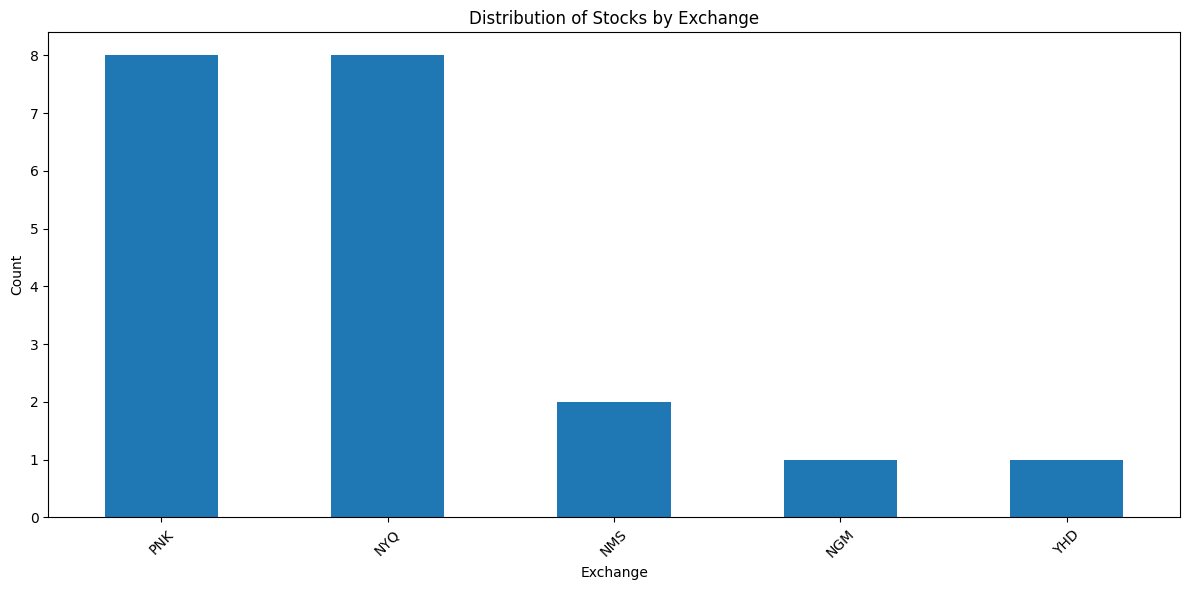

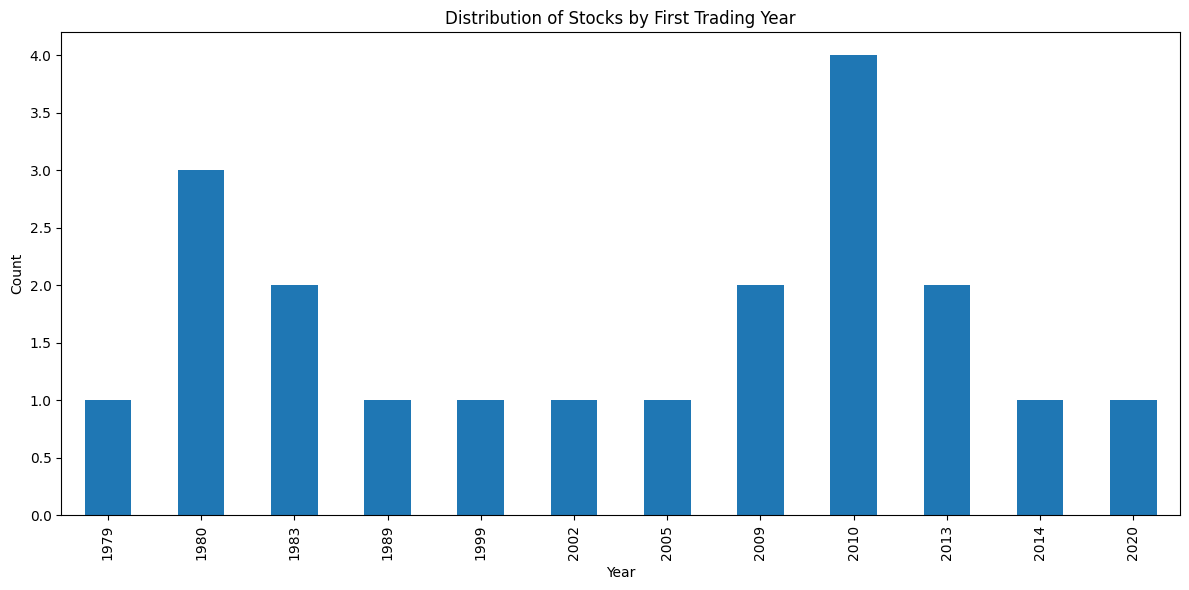

In [12]:
def extract_metadata_features(json_file):
    """Extract valuable metadata features from JSON file"""
    try:
        with open(json_file, 'r') as f:
            data = json.load(f)
    except Exception as e:
        print(f"Error loading JSON file {json_file}: {e}")
        return None
    
    try:
        ticker = os.path.basename(json_file).split('.')[0]
        meta = data['chart']['result'][0]['meta']
        
        # Extract valuable metadata fields
        metadata = {
            'Symbol': ticker,
            'Currency': meta.get('currency'),
            'Exchange': meta.get('exchangeName'),
            'InstrumentType': meta.get('instrumentType'),
            'FirstTradeDate': meta.get('firstTradeDate'),
            'RegularMarketPrice': meta.get('regularMarketPrice'),
            'ChartPreviousClose': meta.get('chartPreviousClose'),
            'PriceHint': meta.get('priceHint'),
            'TimeZone': meta.get('timezone')
        }
        
        # Extract any available trading periods
        if 'tradingPeriods' in meta:
            trading_periods = meta['tradingPeriods']
            if trading_periods and len(trading_periods) > 0 and len(trading_periods[0]) > 0:
                period = trading_periods[0][0]
                metadata.update({
                    'TradingStart': period.get('start'),
                    'TradingEnd': period.get('end'),
                    'TradingTimezone': period.get('timezone')
                })
        
        # Extract current trading state if available
        if 'currentTradingPeriod' in meta:
            current = meta['currentTradingPeriod'].get('regular', {})
            metadata.update({
                'CurrentTradingStart': current.get('start'),
                'CurrentTradingEnd': current.get('end')
            })
            
        return metadata
    except (KeyError, IndexError) as e:
        print(f"Error extracting metadata from {json_file}: {e}")
        return None

# Extract metadata from all sample JSON files
metadata_list = []
for file in json_files[:20]:  # Analyze a reasonable sample
    metadata = extract_metadata_features(file)
    if metadata:
        metadata_list.append(metadata)

# Convert to DataFrame for analysis
metadata_df = pd.DataFrame(metadata_list)

# Analyze metadata distributions
print("Metadata Analysis:")
print(f"Unique exchanges: {metadata_df['Exchange'].unique()}")
print(f"Unique currencies: {metadata_df['Currency'].unique()}")
print(f"Unique instrument types: {metadata_df['InstrumentType'].unique()}")

# Distribution of stocks by exchange
plt.figure(figsize=(12, 6))
metadata_df['Exchange'].value_counts().plot(kind='bar')
plt.title('Distribution of Stocks by Exchange')
plt.xlabel('Exchange')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze first trade dates
if 'FirstTradeDate' in metadata_df.columns:
    plt.figure(figsize=(12, 6))
    pd.to_datetime(metadata_df['FirstTradeDate'], unit='s').dt.year.value_counts().sort_index().plot(kind='bar')
    plt.title('Distribution of Stocks by First Trading Year')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

### Justification of Dimensionality Reduction

While dimensionality reduction techniques like LASSO, PCA, or feature selection methods are common in machine learning workflows, our stock price forecasting project has several characteristics that make these approaches less necessary:

#### Domain-Specific Feature Engineering

- Our features are carefully engineered based on financial domain knowledge
- Technical indicators (MA7, RSI, volatility metrics) each capture unique market behaviors
- Price-based features have established relationships with future returns in finance literature

#### Data Structure Considerations

- Time series data benefits from temporal indicators that may appear correlated but capture different time horizons
- Financial markets exhibit regime-dependent behavior where features' importance shifts across market conditions
- Regularization in the ML model can handle feature collinearity without explicit dimension reduction

#### Computational Efficiency

- PySpark's distributed computing environment efficiently handles our feature dimensionality
- Our sliding window validation approach provides natural protection against overfitting
- Feature scaling with StandardScaler addresses the different scales without reducing dimensions

#### Analysis Benefits

- Preserving interpretable features allows for better model explanation to stakeholders
- Individual feature importance can be assessed post-training with coefficient analysis
- Market-specific insights might be lost if dimensions are reduced via methods like PCA

For these reasons, we've chosen to maintain our rich feature set while relying on model regularization and proper validation to manage potential overfitting concerns.


## 2. Transformation & Feature Engineering

### Missing Value Handling

Multiple strategies are implemented to address missing values:

1. **Critical Data Validation**:
   - Rows with null dates or missing core price data (Open, Close) are removed
   - Extreme outliers in returns (>±50%) are filtered as likely errors

2. **Technical Indicators**:
   - Missing values in derived features are filled with 0
   - This addresses nulls from calculation windows (e.g., first N days of moving averages)

3. **Metadata Fields**:
   - Non-critical columns (those not part of core price/volume data) have nulls filled with appropriate defaults
   - JSON metadata fields may not exist for all tickers, so they are selectively added

4. **Batch Processing Approach**:
   - DataFrames are processed and checkpointed in batches
   - This allows handling large datasets that might not fit in memory
   - Each batch is saved as a parquet file before final combination

This approach balances data completeness with quality, ensuring we maintain essential trading information while maximizing the available features for analysis and model training.


### Handle the non-numerical values


#### Identification & Handling

- **Target features**: Currency, exchange, instrumentType, timezone
- **Missing values**: Filled with domain-appropriate defaults (USD, UNKNOWN, EQUITY, America/New_York)
- **Consistency**: All string-type metadata standardized to prevent downstream issues


#### Feature Engineering

- **Geographic mapping**: Timezones converted to market regions (AMERICAS, EUROPE, ASIA, ASIA_PACIFIC)
- **Composite features**: Created market_id from exchange+currency combination
- **Metadata consolidation**: Non-critical string columns standardized with consistent defaults

#### ML Preparation

- **StringIndexer**: All categorical features converted to numerical indices
- **OneHotEncoder**: High-cardinality features (exchange, market_id) transformed to sparse vectors
- **Invalid handling**: "keep" strategy maintains data integrity when new categories appear

In [13]:
def clean_and_handle_missing_values(df):
    """
    Clean data and handle missing values
    
    Args:
        df: PySpark DataFrame with features
    
    Returns:
        Cleaned PySpark DataFrame
    """
    # Count rows before cleaning
    initial_count = df.count()
    print(f"Initial row count: {initial_count}")
    
    # Remove rows with null dates or missing basic price data
    cleaned_df = df.filter(
        col("Date").isNotNull() &
        col("Close").isNotNull() &
        col("Open").isNotNull()
    )
    
    # Count rows after removing null essential data
    basic_cleaned_count = cleaned_df.count()
    print(f"Rows after basic cleaning: {basic_cleaned_count} ({basic_cleaned_count/initial_count:.2%} of original)")
    
    # For engineered features, we have several options:
    # 1. Drop rows with any nulls (strict but could lose a lot of data)
    # 2. Fill nulls with defaults (0, mean, etc.)
    # 3. Use more sophisticated imputation
    
    # Option 2: Fill nulls with appropriate defaults
    # For ratio and technical indicators, nulls often come from calculation windows
    # Fill numeric columns with 0 where appropriate
    numeric_cols = [f.name for f in cleaned_df.schema.fields 
                   if isinstance(f.dataType, (DoubleType, IntegerType)) 
                   and f.name not in ["Open", "High", "Low", "Close", "Volume", "Adjusted_Close"]]
    
    # Fill missing values in derived features
    for col_name in numeric_cols:
        cleaned_df = cleaned_df.withColumn(
            col_name, 
            when(col(col_name).isNull(), 0).otherwise(col(col_name))
        )
    
    # Remove rows with extreme outliers in returns
    # Filter out extreme values that are likely data errors
    cleaned_df = cleaned_df.filter(
        (col("Return").isNull()) | 
        (abs(col("Return")) < 0.5)  # Filter returns > ±50% as likely errors
    )
    
    # Count rows after all cleaning
    final_count = cleaned_df.count()
    print(f"Final row count: {final_count} ({final_count/initial_count:.2%} of original)")
    
    return cleaned_df

In [44]:
def clean_and_handle_missing_values_improved(df):
    """
    Clean data and handle missing values with improved approach
    
    Args:
        df: PySpark DataFrame with features
    
    Returns:
        Cleaned PySpark DataFrame
    """
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import abs as spark_abs
    
    # Count rows before cleaning
    initial_count = df.count()
    print(f"Initial row count: {initial_count}")
    
    # Check null counts in essential columns
    null_counts = {}
    for column in ["Date", "Close", "Open", "Symbol"]:
        if column in df.columns:
            null_count = df.filter(col(column).isNull()).count()
            null_counts[column] = null_count
    
    print("Null counts in essential columns:")
    for col_name, count in null_counts.items():
        print(f"- {col_name}: {count} nulls ({count/initial_count:.2%})")
    
    # Remove rows with null dates or missing basic price data
    cleaned_df = df.filter(
        col("Date").isNotNull() &
        col("Close").isNotNull() &
        col("Open").isNotNull()
    )
    
    # Count rows after removing null essential data
    basic_cleaned_count = cleaned_df.count()
    print(f"Rows after basic cleaning: {basic_cleaned_count} ({basic_cleaned_count/initial_count:.2%} of original)")
    
    # Get list of numeric columns for different treatment strategies
    price_cols = ["Open", "High", "Low", "Close", "Volume", "Adjusted_Close"]
    derived_cols = [f.name for f in cleaned_df.schema.fields 
                   if isinstance(f.dataType, (DoubleType, IntegerType)) 
                   and f.name not in price_cols
                   and not f.name.startswith("Target_")]
    
    target_cols = [f.name for f in cleaned_df.schema.fields 
                  if f.name.startswith("Target_")]
    
    # Identify categorical and metadata columns
    categorical_cols = ["currency", "exchange", "instrumentType", "timezone"]
    # For the other columns, not need to use.
    # metadata_cols = [f.name for f in cleaned_df.schema.fields 
    #                 if isinstance(f.dataType, StringType) 
    #                 and f.name not in ["Symbol", "Date"] 
    #                 and f.name not in categorical_cols]
    
    # Check for null values in these column groups
    print("\nNull value counts after basic cleaning:")
    for col_type, columns in [("Price", price_cols), 
                             ("Derived", derived_cols[:5] + ["..."]), 
                             ("Target", target_cols[:5] + ["..."]),
                             ("Categorical", categorical_cols)]:
        for col_name in columns:
            if col_name != "...":
                if col_name in cleaned_df.columns:
                    null_count = cleaned_df.filter(col(col_name).isNull()).count()
                    print(f"- {col_type}: {col_name}: {null_count} nulls ({null_count/basic_cleaned_count:.2%})")
    
    # Handle null values in price columns (more strict)
    # For most price data we require it to be present
    for col_name in price_cols:
        if col_name in cleaned_df.columns:
            cleaned_df = cleaned_df.filter(col(col_name).isNotNull())
    
    # For derived metrics, fill with appropriate defaults
    # Fill zeros for ratios, moving averages and other metrics that are calculated
    for col_name in derived_cols:
        if col_name in cleaned_df.columns:
            cleaned_df = cleaned_df.withColumn(
                col_name, 
                when(col(col_name).isNull(), 0).otherwise(col(col_name))
            )
    
    # Handle categorical columns with appropriate defaults
    if "currency" in cleaned_df.columns:
        cleaned_df = cleaned_df.withColumn(
            "currency", 
            when(col("currency").isNull(), "USD").otherwise(col("currency"))
        )
    
    if "exchange" in cleaned_df.columns:
        cleaned_df = cleaned_df.withColumn(
            "exchange", 
            when(col("exchange").isNull(), "UNKNOWN").otherwise(col("exchange"))
        )
    
    if "instrumentType" in cleaned_df.columns:
        cleaned_df = cleaned_df.withColumn(
            "instrumentType", 
            when(col("instrumentType").isNull(), "EQUITY").otherwise(col("instrumentType"))
        )
    
    # Special handling for timezone data
    if "timezone" in cleaned_df.columns:
        # Standardize timezone format and fill missing with default
        cleaned_df = cleaned_df.withColumn(
            "timezone", 
            when(col("timezone").isNull(), "America/New_York")  # Default US market timezone
            .otherwise(col("timezone"))
        )
        
        # Create timezone category based on major financial markets
        cleaned_df = cleaned_df.withColumn(
            "market_region",
            when(col("timezone").like("%America%"), "AMERICAS")
            .when(col("timezone").like("%Europe%"), "EUROPE")
            .when(col("timezone").like("%Asia%"), "ASIA")
            .when(col("timezone").like("%Australia%"), "ASIA_PACIFIC")
            .otherwise("OTHER")
        )
    
    # # For other metadata columns, fill with appropriate defaults
    # for col_name in metadata_cols:
    #     if col_name in cleaned_df.columns:
    #         cleaned_df = cleaned_df.withColumn(
    #             col_name, 
    #             when(col(col_name).isNull(), "UNKNOWN").otherwise(col(col_name))
    #         )
    
    # CRITICAL NEW ADDITION: Convert categorical variables to numerical
    # This makes them usable by ML algorithms
    categorical_features_to_encode = []
    
    # Only include categorical columns that actually exist in the DataFrame
    for col_name in categorical_cols + ["market_region"]:
        if col_name in cleaned_df.columns:
            categorical_features_to_encode.append(col_name)
    
    # # Add any metadata columns that might be categorical
    # for col_name in metadata_cols:
    #     if col_name in cleaned_df.columns:
    #         categorical_features_to_encode.append(col_name)
    
    # Process categorical columns with StringIndexer and OneHotEncoder
    indexed_cols = []
    encoded_cols = []
    
    if categorical_features_to_encode:
        print("\nEncoding categorical features for ML:")
        print(f"- Features to encode: {categorical_features_to_encode}")
        
        # Create and apply string indexers for each categorical column
        for cat_col in categorical_features_to_encode:
            # Create a new indexed column name
            indexed_col = f"{cat_col}_indexed"
            indexed_cols.append(indexed_col)
            
            # Create and fit the string indexer
            indexer = StringIndexer(
                inputCol=cat_col, 
                outputCol=indexed_col,
                handleInvalid="keep"  # Options: keep, skip, error
            )
            
            # Apply the indexer
            cleaned_df = indexer.fit(cleaned_df).transform(cleaned_df)
        
        # If exchange and currency are both present, create a composite feature
        if "exchange" in cleaned_df.columns and "currency" in cleaned_df.columns:
            # Create a market identifier (exchange + currency is a unique market identifier)
            cleaned_df = cleaned_df.withColumn(
                "market_id", 
                concat_ws("_", col("exchange"), col("currency"))
            )
            
            # Index this new composite feature
            market_indexer = StringIndexer(
                inputCol="market_id", 
                outputCol="market_id_indexed",
                handleInvalid="keep"
            )
            cleaned_df = market_indexer.fit(cleaned_df).transform(cleaned_df)
            indexed_cols.append("market_id_indexed")
        
        # For high-cardinality features (like exchange), apply one-hot encoding
        high_cardinality_cols = ["exchange_indexed", "market_id_indexed"]
        cols_to_encode = [col for col in high_cardinality_cols if col in cleaned_df.columns]
        
        if cols_to_encode:
            encoder = OneHotEncoder(
                inputCols=cols_to_encode,
                outputCols=[f"{col.replace('_indexed', '')}_vec" for col in cols_to_encode],
                dropLast=True
            )
            
            # Apply the encoder
            cleaned_df = encoder.fit(cleaned_df).transform(cleaned_df)
            
            # Add encoded columns to track them
            encoded_cols = [f"{col.replace('_indexed', '')}_vec" for col in cols_to_encode]
    
    # For target columns, we need to decide whether to drop rows or impute
    # Here we'll drop rows where required target columns are missing
    required_targets = ["Target_Direction_1d", "Target_Return_1d"]  # Example
    for col_name in required_targets:
        if col_name in cleaned_df.columns:
            cleaned_df = cleaned_df.filter(col(col_name).isNotNull())
    
    # Remove extreme outliers in returns
    if "Return" in cleaned_df.columns:
        cleaned_df = cleaned_df.filter(
            (col("Return").isNull()) | 
            (spark_abs(col("Return")) < 0.5)  # Filter returns > ±50% as likely errors
        )
    
    # Count rows after all cleaning
    final_count = cleaned_df.count()
    print(f"Final row count: {final_count} ({final_count/initial_count:.2%} of original)")
    
    # Record the list of all ML-ready features in a new column
    numeric_features = price_cols + derived_cols
    numeric_features = [c for c in numeric_features if c in cleaned_df.columns]
    
    all_ml_features = numeric_features + indexed_cols + encoded_cols
    # Store this list as metadata in the DataFrame properties for future reference
    # cleaned_df = cleaned_df.withColumn("_ML_FEATURES", lit(",".join(all_ml_features)))
    
    return cleaned_df, all_ml_features

### Target variables for stock price forecasting

For stock price forecasting, we need to carefully select our target variables based on both theoretical considerations and practical applications. Here are the refined target variables we'll use:

1. **Next-Day Return** (Target_Return_1d)

   - Definition: The percentage change in price from today's close to tomorrow's close

   - Formula: $(Close_{t+1} - Close_t) / Close_t$

   - Rationale: Returns are stationary and comparable across different stocks, making them better prediction targets than raw prices

2. **Next-Week Return** (Target_Return_1d)

   - Definition: The percentage change in price from today's close to next week's close

   - Formula: $(Close_{t+7} - Close_t) / Close_t$

   - Rationale: Returns are stationary and comparable across different stocks, making them better prediction targets than raw prices

2. **Next-Month Return** (Target_Return_1d)

   - Definition: The percentage change in price from today's close to next month's close

   - Formula: $(Close_{t+30} - Close_t) / Close_t$

   - Rationale: Returns are stationary and comparable across different stocks, making them better prediction targets than raw prices


For the three target, each has its own meaning and representation and we shall discover the usage and result of different evaluation metric.

In [45]:
def create_comprehensive_targets(df):
    """Create comprehensive set of target variables"""
    # Define window specifications for future calculations
    window_by_stock = Window.partitionBy("Symbol").orderBy("Date")
    
    # Add future close prices
    for days in [1, 5, 10, 21]:
        df = df.withColumn(f"FutureClose_{days}d", lead("Close", days).over(window_by_stock))
    
    # Calculate return targets
    for days in [1, 5, 10, 21]:
        df = df.withColumn(
            f"Target_Return_{days}d", 
            (col(f"FutureClose_{days}d") - col("Close")) / col("Close")
        )
        
        # Add direction targets (binary classification)
        df = df.withColumn(
            f"Target_Direction_{days}d",
            when(col(f"Target_Return_{days}d") > 0, 1).otherwise(0)
        )
    
    # Calculate volatility targets
    # For 5-day volatility, we need the daily returns for the next 5 days
    for i in range(1, 6):
        df = df.withColumn(
            f"Return_next_{i}d", 
            lead(col("Return"), i).over(window_by_stock)
        )
    
    # First calculate the average of the next 5 days' returns
    df = df.withColumn(
        "Avg_Next_5d_Returns",
        (col("Return_next_1d") + col("Return_next_2d") + col("Return_next_3d") + 
         col("Return_next_4d") + col("Return_next_5d")) / 5
    )
    
    # Then calculate the volatility as the standard deviation
    df = df.withColumn(
        "Target_Volatility_5d",
        sqrt(
            (pow(col("Return_next_1d") - col("Avg_Next_5d_Returns"), 2) +
             pow(col("Return_next_2d") - col("Avg_Next_5d_Returns"), 2) +
             pow(col("Return_next_3d") - col("Avg_Next_5d_Returns"), 2) +
             pow(col("Return_next_4d") - col("Avg_Next_5d_Returns"), 2) +
             pow(col("Return_next_5d") - col("Avg_Next_5d_Returns"), 2)) / 5
        )
    )
    
    # Add extreme movement targets (> 2%, > 5%)
    # Import the correct abs function from pyspark.sql.functions
    from pyspark.sql.functions import abs as spark_abs
    
    for days in [1, 5]:
        df = df.withColumn(
            f"Target_ExtMove2pct_{days}d",
            when(spark_abs(col(f"Target_Return_{days}d")) > 0.02, 1).otherwise(0)
        )
        df = df.withColumn(
            f"Target_ExtMove5pct_{days}d",
            when(spark_abs(col(f"Target_Return_{days}d")) > 0.05, 1).otherwise(0)
        )
    
    return df

In [46]:
def add_technical_features(df):
    """
    Add technical indicators and features to the stock data DataFrame
    
    Args:
        df: PySpark DataFrame with stock price data
    
    Returns:
        PySpark DataFrame with additional features
    """
    # Define window specifications for different periods
    window_by_stock = Window.partitionBy("Symbol").orderBy("Date")
    window_7d = Window.partitionBy("Symbol").orderBy("Date").rowsBetween(-7, 0)
    window_14d = Window.partitionBy("Symbol").orderBy("Date").rowsBetween(-14, 0)
    window_30d = Window.partitionBy("Symbol").orderBy("Date").rowsBetween(-30, 0)
    window_90d = Window.partitionBy("Symbol").orderBy("Date").rowsBetween(-90, 0)
    
    # Add basic features
    enhanced_df = df \
        .withColumn("PrevClose", lag("Close", 1).over(window_by_stock)) \
        .withColumn("Return", (col("Close") - col("PrevClose")) / col("PrevClose")) \
        .withColumn("LogReturn", log(col("Close") / col("PrevClose")))
    
    # Add moving averages
    enhanced_df = enhanced_df \
        .withColumn("MA7", avg("Close").over(window_7d)) \
        .withColumn("MA30", avg("Close").over(window_30d)) \
        .withColumn("MA90", avg("Close").over(window_90d))
    
    # Add price relative to moving averages
    enhanced_df = enhanced_df \
        .withColumn("Close_MA7_Ratio", col("Close") / col("MA7")) \
        .withColumn("Close_MA30_Ratio", col("Close") / col("MA30")) \
        .withColumn("MA7_MA30_Ratio", col("MA7") / col("MA30"))
    
    # Add volatility indicators
    enhanced_df = enhanced_df \
        .withColumn("STD7", stddev("Close").over(window_7d)) \
        .withColumn("STD30", stddev("Close").over(window_30d)) \
        .withColumn("VolatilityRatio", col("STD7") / col("STD30"))
    
    # Add range and momentum indicators
    enhanced_df = enhanced_df \
        .withColumn("HighLowRange", col("High") - col("Low")) \
        .withColumn("HighLowRangeRatio", col("HighLowRange") / col("Close")) \
        .withColumn("CloseDelta", col("Close") - col("Open")) \
        .withColumn("CloseOpenRatio", col("Close") / col("Open"))
    
    # Add volume indicators
    enhanced_df = enhanced_df \
        .withColumn("VolumeDelta", col("Volume") - lag("Volume", 1).over(window_by_stock)) \
        .withColumn("VolumeMA7", avg("Volume").over(window_7d)) \
        .withColumn("VolumeMA30", avg("Volume").over(window_30d)) \
        .withColumn("RelativeVolume", col("Volume") / col("VolumeMA30")) \
        .withColumn("MoneyFlow", col("Volume") * (col("Close") - col("Open")))
    
    # Add high/low indicators
    enhanced_df = enhanced_df \
        .withColumn("MaxHigh7", max("High").over(window_7d)) \
        .withColumn("MinLow7", min("Low").over(window_7d)) \
        .withColumn("MaxHigh30", max("High").over(window_30d)) \
        .withColumn("MinLow30", min("Low").over(window_30d))
    
    # Calculate positions relative to ranges
    enhanced_df = enhanced_df \
        .withColumn("CloseToHighPos7", (col("Close") - col("MinLow7")) / (col("MaxHigh7") - col("MinLow7"))) \
        .withColumn("CloseToHighPos30", (col("Close") - col("MinLow30")) / (col("MaxHigh30") - col("MinLow30")))
    
    # Add RSI (14-day)
    enhanced_df = enhanced_df \
        .withColumn("UpMove", when(col("Close") > lag("Close", 1).over(window_by_stock), 
                                  col("Close") - lag("Close", 1).over(window_by_stock)).otherwise(0)) \
        .withColumn("DownMove", when(col("Close") < lag("Close", 1).over(window_by_stock), 
                                    lag("Close", 1).over(window_by_stock) - col("Close")).otherwise(0)) \
        .withColumn("AvgUp14", avg("UpMove").over(window_14d)) \
        .withColumn("AvgDown14", avg("DownMove").over(window_14d)) \
        .withColumn("RS", col("AvgUp14") / when(col("AvgDown14") == 0, 0.001).otherwise(col("AvgDown14"))) \
        .withColumn("RSI", 100 - (100 / (1 + col("RS"))))
    
    # Return the enhanced DataFrame
    return enhanced_df

In [17]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

def scale_features(train_df, val_df, test_df, feature_cols):
    """
    Scale features using StandardScaler fit on training data only
    
    Args:
        train_df: Training DataFrame
        val_df: Validation DataFrame
        test_df: Test DataFrame
        feature_cols: List of feature column names to scale
    
    Returns:
        Tuple of (scaled_train_df, scaled_val_df, scaled_test_df)
    """
    # Assemble features into a vector
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vec")
    
    # Assemble each dataset
    train_assembled = assembler.transform(train_df)
    val_assembled = assembler.transform(val_df)
    test_assembled = assembler.transform(test_df)
    
    # Fit scaler on training data only
    scaler = StandardScaler(inputCol="features_vec", outputCol="scaled_features")
    scaler_model = scaler.fit(train_assembled)
    
    # Transform all datasets using the scaler fit on training data
    train_scaled = scaler_model.transform(train_assembled)
    val_scaled = scaler_model.transform(val_assembled)
    test_scaled = scaler_model.transform(test_assembled)
    
    return train_scaled, val_scaled, test_scaled


In [47]:
def process_full_dataset(csv_dir, json_dir, output_dir, sample_size=None):
    """
    Process the entire stock market dataset with both CSV and JSON data
    
    Args:
        csv_dir: Directory containing CSV files
        json_dir: Directory containing JSON files
        output_dir: Directory to save processed data
        sample_size: Optional limit to number of stocks to process
    """
    # Get list of files
    csv_files = glob.glob(os.path.join(csv_dir, "*.csv"))
    json_files = glob.glob(os.path.join(json_dir, "*.json"))
    
    # Create lookup for JSON files by ticker
    json_lookup = {os.path.basename(f).split('.')[0]: f for f in json_files}
    
    # Limit sample size if specified
    if sample_size:
        csv_files = csv_files[:sample_size]
    
    print(f"Processing {len(csv_files)} stocks...")
    
    # Schema for CSV files
    csv_schema = StructType([
        StructField("Date", StringType(), True),
        StructField("Low", DoubleType(), True),
        StructField("Open", DoubleType(), True),
        StructField("Volume", IntegerType(), True),
        StructField("High", DoubleType(), True),
        StructField("Close", DoubleType(), True),
        StructField("Adjusted Close", DoubleType(), True)
    ])
    
    # Process each stock
    processed_dfs = []
    
    for i, csv_file in enumerate(csv_files):
        ticker = os.path.basename(csv_file).split('.')[0]
        
        if i % 50 == 0:
            print(f"Processing stock {i+1}/{len(csv_files)}: {ticker}")
        
        try:
            # Read CSV data
            stock_df = spark.read.csv(csv_file, header=True, schema=csv_schema)
            stock_df = stock_df.withColumn("Symbol", lit(ticker))
            stock_df = stock_df.withColumn("Date", to_date(col("Date"), "dd-MM-yyyy"))
            
            # Add JSON metadata if available
            if ticker in json_lookup:
                with open(json_lookup[ticker], 'r') as f:
                    json_data = json.load(f)
                
                try:
                    meta = json_data['chart']['result'][0]['meta']
                    json_features = {
                        "currency": meta.get("currency"),
                        "exchange": meta.get("exchangeName"),
                        "instrumentType": meta.get("instrumentType"),
                        "firstTradeDate": meta.get("firstTradeDate"),
                        "priceHint": meta.get("priceHint"),
                        "timezone": meta.get("timezone")
                    }
                    
                    # Add JSON features as columns
                    for feature, value in json_features.items():
                        if value is not None:
                            stock_df = stock_df.withColumn(feature, lit(value))
                
                except (KeyError, IndexError) as e:
                    print(f"Error extracting JSON data for {ticker}: {e}")
            
            # Add to list of processed DataFrames
            processed_dfs.append(stock_df)
            
            # Periodically combine and checkpoint
            if len(processed_dfs) >= 100 or i == len(csv_files) - 1:
                print(f"Combining {len(processed_dfs)} processed stocks...")
                
                # Combine processed DataFrames
                if processed_dfs:
                    combined_df = processed_dfs[0]
                    for df in processed_dfs[1:]:
                        combined_df = combined_df.unionByName(df, allowMissingColumns=True)
                    
                    # Fill nulls in non-critical columns
                    for col_name in combined_df.columns:
                        if col_name not in ["Date", "Symbol", "Open", "High", "Low", "Close", "Volume"]:
                            combined_df = combined_df.fillna(0, subset=[col_name])
                    
                    # Save intermediate result
                    checkpoint_path = f"{output_dir}/stocks_batch_{i//100}"
                    combined_df.write.parquet(checkpoint_path, mode="overwrite")
                    print(f"Saved intermediate batch to {checkpoint_path}")
                    
                    # Clear list
                    processed_dfs = []
        
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
    
    print("Processing complete. Final steps...")
    
    # Combine all checkpointed batches
    all_batches = glob.glob(os.path.join(output_dir, "stocks_batch_*"))
    if all_batches:
        final_df = spark.read.parquet(all_batches[0])
        for batch_path in all_batches[1:]:
            batch_df = spark.read.parquet(batch_path)
            final_df = final_df.unionByName(batch_df, allowMissingColumns=True)
        
        # Add features and targets
        final_df = add_technical_features(final_df)
        final_df = create_comprehensive_targets(final_df)
        
        # Save final result
        final_path = f"{output_dir}/full_processed_data"
        final_df.write.parquet(final_path, mode="overwrite")
        print(f"Saved final processed dataset to {final_path}")
        
        return final_df
    else:
        print("No data batches found!")
        return None

# Example usage (commented out to avoid execution)
final_dataset = process_full_dataset(
    csv_dir="data/stock_market_data/forbes2000/csv",
    json_dir="data/stock_market_data/forbes2000/json",
    output_dir="processed_data",
    sample_size=200  # Process first 200 files
)

Processing 200 stocks...
Processing stock 1/200: CSCO
Processing stock 51/200: CS
Combining 100 processed stocks...


Saved intermediate batch to processed_data/stocks_batch_0
Processing stock 101/200: IHCPF
Processing stock 151/200: LNG
Combining 100 processed stocks...


Saved intermediate batch to processed_data/stocks_batch_1
Processing complete. Final steps...


Saved final processed dataset to processed_data/full_processed_data


## 3. Baseline Model Exploration

### Create Training, Validation, and Test Sets

In [3]:
from pyspark.sql.functions import year, col, min as spark_min, max as spark_max
def create_sliding_time_splits(df, train_span=5, val_span=1, checkpoint_dir=None, use_checkpoint=True, overwrite_checkpoint=False, strating_year = 2010):
    """
    Creates sliding time-based splits for training and validation, then leaves the
    remaining years as the test set.
    
    For example, if train_span=5 and val_span=1, and the dataset spans at least 7+ years:
      - Split 1: Train = years [Y..Y+4], Val = [Y+5]
      - Split 2: Train = years [Y+1..Y+5], Val = [Y+6]
      - ...
      - Final: Remaining years after the last validation fold = Test set
    
    Args:
        df (DataFrame): Spark DataFrame with a Date column.
        train_span (int): Number of consecutive years in the training set.
        val_span (int): Number of consecutive years in the validation set.
        checkpoint_dir (str): Directory to save/load checkpointed data.
        use_checkpoint (bool): Whether to load from checkpoint if available.
        overwrite_checkpoint (bool): Whether to overwrite existing checkpoints.
        
    Returns:
        splits (list of tuples): Each element is (train_df, val_df) for that fold.
        test_df (DataFrame): The final test set containing the remaining years 
                             after the last validation fold.
    """
    import os
    
    # 1. Add a "Year" column for time-based filtering
    df_with_year = df.withColumn("Year", year(col("Date")))
    
    # Filter data to start from the specified starting year
    df_with_year = df_with_year.filter(col("Year") >= strating_year)

    # 2. Identify the min and max year in the dataset
    year_stats = df_with_year.agg(spark_min("Year"), spark_max("Year")).collect()
    min_year = year_stats[0][0]
    max_year = year_stats[0][1]
    
    print(f"Dataset spans from year {min_year} to year {max_year}.")
    
    # If checkpoint directory is provided, use it
    if checkpoint_dir:
        # Create directory if it doesn't exist
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
            print(f"Created checkpoint directory: {checkpoint_dir}")
        
        # Path for metadata about the splits
        metadata_path = os.path.join(checkpoint_dir, "split_metadata")
        
        # Check if we can load from checkpoint
        if use_checkpoint and os.path.exists(metadata_path) and not overwrite_checkpoint:
            print(f"Loading splits from checkpoint: {checkpoint_dir}")
            try:
                metadata_df = spark.read.parquet(metadata_path)
                metadata = metadata_df.collect()[0]
                
                # Extract parameters from metadata
                saved_min_year = metadata["min_year"]
                saved_max_year = metadata["max_year"]
                saved_train_span = metadata["train_span"]
                saved_val_span = metadata["val_span"]
                fold_count = metadata["fold_count"]
                
                # Verify parameters match
                if (saved_min_year == min_year and saved_max_year == max_year and
                    saved_train_span == train_span and saved_val_span == val_span):
                    
                    # Load splits from checkpoint
                    splits = []
                    for i in range(fold_count):
                        train_path = os.path.join(checkpoint_dir, f"train_fold_{i}")
                        val_path = os.path.join(checkpoint_dir, f"val_fold_{i}")
                        
                        if os.path.exists(train_path) and os.path.exists(val_path):
                            train_df = spark.read.parquet(train_path)
                            val_df = spark.read.parquet(val_path)
                            splits.append((train_df, val_df))
                    
                    # Load test set
                    test_path = os.path.join(checkpoint_dir, "test_set")
                    if os.path.exists(test_path):
                        test_df = spark.read.parquet(test_path)
                        
                        print(f"Successfully loaded {len(splits)} splits and test set from checkpoint.")
                        return splits, test_df
                    else:
                        print("Test set not found in checkpoint. Will recompute splits.")
                else:
                    print("Checkpoint parameters don't match current run. Will recompute splits.")
            except Exception as e:
                print(f"Error loading from checkpoint: {e}. Will recompute splits.")
    
    # 3. Build each (train, val) fold in a sliding-window approach
    splits = []
    current_start = min_year
    
    # Track the final validation end year for test set creation
    final_val_end = None
    
    while True:
        train_start = current_start
        train_end = train_start + train_span - 1   # inclusive
        val_start = train_end + 1
        val_end = val_start + val_span - 1         # inclusive
        
        # If we can't form a validation window without running into the test region, break
        if val_end >= max_year:
            break
        
        print(f"Creating fold {len(splits)+1}: Train [{train_start}-{train_end}], Val [{val_start}-{val_end}]")
        
        # Create train and val DataFrames
        train_df = df_with_year.filter(
            (col("Year") >= train_start) & (col("Year") <= train_end)
        )

        val_df = df_with_year.filter(
            (col("Year") >= val_start) & (col("Year") <= val_end)
        )

        # Clean the data
        train_df, all_ml_features = clean_and_handle_missing_values_improved(train_df)
        val_df, all_ml_features = clean_and_handle_missing_values_improved(val_df)
        
        # Checkpoint the data if directory is provided
        if checkpoint_dir:
            train_path = os.path.join(checkpoint_dir, f"train_fold_{len(splits)}")
            val_path = os.path.join(checkpoint_dir, f"val_fold_{len(splits)}")
            
            train_df.write.parquet(train_path, mode="overwrite")
            val_df.write.parquet(val_path, mode="overwrite")
            print(f"Checkpointed fold {len(splits)+1} to {checkpoint_dir}")
        
        # Collect them as a split
        splits.append((train_df, val_df))
        
        # Update final_val_end for test set creation
        final_val_end = val_end
        
        # Move the start year by 1 for the next sliding window
        current_start += 1
    
    # 4. Create the test set from data after the last validation window
    if len(splits) > 0:
        test_df = df_with_year.filter(col("Year") > final_val_end)
    else:
        # Edge case: If no splits formed (e.g., not enough data),
        # we consider the entire dataset as test
        test_df = df_with_year
    
    # Clean the test set
    test_df, all_ml_features = clean_and_handle_missing_values_improved(test_df)
    
    # Checkpoint the test set if directory is provided
    if checkpoint_dir:
        test_path = os.path.join(checkpoint_dir, "test_set")
        test_df.write.parquet(test_path, mode="overwrite")
        
        # Save all_ml_features
        ml_features_path = os.path.join(checkpoint_dir, "all_ml_features")
        with open(ml_features_path, "w") as f:
            for feature in all_ml_features:
                f.write(f"{feature}\n")

        # Save metadata about the splits
        from pyspark.sql.types import StructType, StructField, IntegerType
        
        metadata_schema = StructType([
            StructField("min_year", IntegerType(), False),
            StructField("max_year", IntegerType(), False),
            StructField("train_span", IntegerType(), False),
            StructField("val_span", IntegerType(), False),
            StructField("fold_count", IntegerType(), False)
        ])
        
        metadata_df = spark.createDataFrame(
            [(min_year, max_year, train_span, val_span, len(splits))],
            schema=metadata_schema
        )
        
        metadata_df.write.parquet(os.path.join(checkpoint_dir, "split_metadata"), mode="overwrite")
        print(f"Checkpointed test set and metadata to {checkpoint_dir}")
    
    print(f"Created {len(splits)} training/validation folds.")
    print("Leaving the remaining data as test set.")
    
    return splits, test_df

In [49]:
checkpoint_dir = "sliding_time_splits"
starting_year = 2015
splits, test_df = create_sliding_time_splits(final_dataset, train_span=5, val_span=1, checkpoint_dir=checkpoint_dir, use_checkpoint=True, overwrite_checkpoint=False, strating_year = starting_year)

# splits is a list of (train_df, val_df) for each fold.
# test_df is everything after the last validation fold.

# Examine how many folds we have
print(len(splits))

# Check the first fold
train_fold_1, val_fold_1 = splits[0]
print("First fold training years:", 
      train_fold_1.selectExpr("MIN(Year) as minYear", "MAX(Year) as maxYear").show())
print("First fold validation years:", 
      val_fold_1.selectExpr("MIN(Year) as minYear", "MAX(Year) as maxYear").show())

# Check the final test set
print("Test set year range:", 
      test_df.selectExpr("MIN(Year) as minYear", "MAX(Year) as maxYear").show())


Dataset spans from year 2015 to year 2022.
Created checkpoint directory: sliding_time_splits
Creating fold 1: Train [2015-2019], Val [2020-2020]


Initial row count: 1169569
Null counts in essential columns:
- Date: 0 nulls (0.00%)
- Close: 6439 nulls (0.55%)
- Open: 6439 nulls (0.55%)
- Symbol: 0 nulls (0.00%)


Rows after basic cleaning: 1163130 (99.45% of original)

Null value counts after basic cleaning:
- Price: Open: 0 nulls (0.00%)
- Price: High: 0 nulls (0.00%)
- Price: Low: 0 nulls (0.00%)
- Price: Close: 0 nulls (0.00%)
- Price: Volume: 54875 nulls (4.72%)
- Price: Adjusted_Close: 239190 nulls (20.56%)


- Derived: Adjusted Close: 923940 nulls (79.44%)
- Derived: firstTradeDate: 0 nulls (0.00%)
- Derived: priceHint: 0 nulls (0.00%)


- Derived: PrevClose: 161 nulls (0.01%)


- Derived: Return: 161 nulls (0.01%)
- Target: Target_Return_1d: 126 nulls (0.01%)
- Target: Target_Direction_1d: 0 nulls (0.00%)
- Target: Target_Return_5d: 235 nulls (0.02%)
- Target: Target_Direction_5d: 0 nulls (0.00%)
- Target: Target_Return_10d: 380 nulls (0.03%)
- Categorical: currency: 25999 nulls (2.24%)
- Categorical: exchange: 0 nulls (0.00%)
- Categorical: instrumentType: 0 nulls (0.00%)
- Categorical: timezone: 0 nulls (0.00%)

Encoding categorical features for ML:
- Features to encode: ['currency', 'exchange', 'instrumentType', 'timezone', 'market_region']


Final row count: 881256 (75.35% of original)


Initial row count: 240436
Null counts in essential columns:
- Date: 0 nulls (0.00%)
- Close: 6295 nulls (2.62%)
- Open: 6295 nulls (2.62%)
- Symbol: 0 nulls (0.00%)


Rows after basic cleaning: 234141 (97.38% of original)

Null value counts after basic cleaning:
- Price: Open: 0 nulls (0.00%)
- Price: High: 0 nulls (0.00%)
- Price: Low: 0 nulls (0.00%)
- Price: Close: 0 nulls (0.00%)
- Price: Volume: 7114 nulls (3.04%)
- Price: Adjusted_Close: 48493 nulls (20.71%)


- Derived: Adjusted Close: 185648 nulls (79.29%)
- Derived: firstTradeDate: 0 nulls (0.00%)
- Derived: priceHint: 0 nulls (0.00%)


- Derived: PrevClose: 22 nulls (0.01%)
- Derived: Return: 22 nulls (0.01%)
- Target: Target_Return_1d: 18 nulls (0.01%)
- Target: Target_Direction_1d: 0 nulls (0.00%)
- Target: Target_Return_5d: 44 nulls (0.02%)
- Target: Target_Direction_5d: 0 nulls (0.00%)
- Target: Target_Return_10d: 72 nulls (0.03%)
- Categorical: currency: 1328 nulls (0.57%)
- Categorical: exchange: 0 nulls (0.00%)
- Categorical: instrumentType: 0 nulls (0.00%)
- Categorical: timezone: 0 nulls (0.00%)

Encoding categorical features for ML:
- Features to encode: ['currency', 'exchange', 'instrumentType', 'timezone', 'market_region']


Final row count: 180632 (75.13% of original)


Checkpointed fold 1 to sliding_time_splits
Creating fold 2: Train [2016-2020], Val [2021-2021]


Initial row count: 1180732
Null counts in essential columns:
- Date: 0 nulls (0.00%)
- Close: 12624 nulls (1.07%)
- Open: 12624 nulls (1.07%)
- Symbol: 0 nulls (0.00%)


Rows after basic cleaning: 1168108 (98.93% of original)

Null value counts after basic cleaning:
- Price: Open: 0 nulls (0.00%)
- Price: High: 0 nulls (0.00%)
- Price: Low: 0 nulls (0.00%)
- Price: Close: 0 nulls (0.00%)
- Price: Volume: 50330 nulls (4.31%)
- Price: Adjusted_Close: 240294 nulls (20.57%)


- Derived: Adjusted Close: 927814 nulls (79.43%)
- Derived: firstTradeDate: 0 nulls (0.00%)
- Derived: priceHint: 0 nulls (0.00%)


- Derived: PrevClose: 124 nulls (0.01%)
- Derived: Return: 124 nulls (0.01%)
- Target: Target_Return_1d: 122 nulls (0.01%)
- Target: Target_Direction_1d: 0 nulls (0.00%)
- Target: Target_Return_5d: 246 nulls (0.02%)
- Target: Target_Direction_5d: 0 nulls (0.00%)
- Target: Target_Return_10d: 405 nulls (0.03%)
- Categorical: currency: 21226 nulls (1.82%)
- Categorical: exchange: 0 nulls (0.00%)
- Categorical: instrumentType: 0 nulls (0.00%)
- Categorical: timezone: 0 nulls (0.00%)

Encoding categorical features for ML:
- Features to encode: ['currency', 'exchange', 'instrumentType', 'timezone', 'market_region']


Final row count: 889400 (75.33% of original)


Initial row count: 244261
Null counts in essential columns:
- Date: 0 nulls (0.00%)
- Close: 6837 nulls (2.80%)
- Open: 6837 nulls (2.80%)
- Symbol: 0 nulls (0.00%)


Rows after basic cleaning: 237424 (97.20% of original)

Null value counts after basic cleaning:
- Price: Open: 0 nulls (0.00%)
- Price: High: 0 nulls (0.00%)
- Price: Low: 0 nulls (0.00%)
- Price: Close: 0 nulls (0.00%)
- Price: Volume: 6519 nulls (2.75%)
- Price: Adjusted_Close: 49747 nulls (20.95%)
- Derived: Adjusted Close: 187677 nulls (79.05%)
- Derived: firstTradeDate: 0 nulls (0.00%)
- Derived: priceHint: 0 nulls (0.00%)


- Derived: PrevClose: 29 nulls (0.01%)
- Derived: Return: 29 nulls (0.01%)
- Target: Target_Return_1d: 14 nulls (0.01%)
- Target: Target_Direction_1d: 0 nulls (0.00%)
- Target: Target_Return_5d: 34 nulls (0.01%)
- Target: Target_Direction_5d: 0 nulls (0.00%)
- Target: Target_Return_10d: 36 nulls (0.02%)
- Categorical: currency: 739 nulls (0.31%)
- Categorical: exchange: 0 nulls (0.00%)
- Categorical: instrumentType: 0 nulls (0.00%)
- Categorical: timezone: 0 nulls (0.00%)

Encoding categorical features for ML:
- Features to encode: ['currency', 'exchange', 'instrumentType', 'timezone', 'market_region']


Final row count: 183252 (75.02% of original)


Checkpointed fold 2 to sliding_time_splits


Initial row count: 230822
Null counts in essential columns:
- Date: 0 nulls (0.00%)
- Close: 7538 nulls (3.27%)
- Open: 7538 nulls (3.27%)
- Symbol: 0 nulls (0.00%)


Rows after basic cleaning: 223284 (96.73% of original)

Null value counts after basic cleaning:
- Price: Open: 0 nulls (0.00%)
- Price: High: 0 nulls (0.00%)
- Price: Low: 0 nulls (0.00%)
- Price: Close: 0 nulls (0.00%)
- Price: Volume: 5055 nulls (2.26%)
- Price: Adjusted_Close: 46572 nulls (20.86%)


- Derived: Adjusted Close: 176712 nulls (79.14%)
- Derived: firstTradeDate: 0 nulls (0.00%)
- Derived: priceHint: 0 nulls (0.00%)


- Derived: PrevClose: 7 nulls (0.00%)
- Derived: Return: 7 nulls (0.00%)
- Target: Target_Return_1d: 949 nulls (0.43%)
- Target: Target_Direction_1d: 0 nulls (0.00%)
- Target: Target_Return_5d: 4731 nulls (2.12%)
- Target: Target_Direction_5d: 0 nulls (0.00%)
- Target: Target_Return_10d: 9453 nulls (4.23%)
- Categorical: currency: 311 nulls (0.14%)
- Categorical: exchange: 0 nulls (0.00%)
- Categorical: instrumentType: 0 nulls (0.00%)
- Categorical: timezone: 0 nulls (0.00%)

Encoding categorical features for ML:
- Features to encode: ['currency', 'exchange', 'instrumentType', 'timezone', 'market_region']


Final row count: 172499 (74.73% of original)


Checkpointed test set and metadata to sliding_time_splits
Created 2 training/validation folds.
Leaving the remaining data as test set.
2


+-------+-------+
|minYear|maxYear|
+-------+-------+
|   2015|   2019|
+-------+-------+

First fold training years: None


+-------+-------+
|minYear|maxYear|
+-------+-------+
|   2020|   2020|
+-------+-------+

First fold validation years: None


+-------+-------+
|minYear|maxYear|
+-------+-------+
|   2022|   2022|
+-------+-------+

Test set year range: None


In [4]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor, FMRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

In [13]:
spark.sparkContext.setLogLevel("ERROR")  # Only show ERROR level logs, hide WARN

In [14]:
def run_checkpoint_baseline_mixed_features(checkpoint_dir, fold_index=0, label_col="Target_Return_1d"):
    """
    Run a baseline model with separate processing for numerical and categorical features
    """
    print(f"Loading data from checkpoint directory: {checkpoint_dir}")
    
    # Load data
    train_path = os.path.join(checkpoint_dir, f"train_fold_{fold_index}")
    val_path = os.path.join(checkpoint_dir, f"val_fold_{fold_index}")
    test_path = os.path.join(checkpoint_dir, "test_set")
    
    train_df = spark.read.parquet(train_path)
    val_df = spark.read.parquet(val_path)
    test_df = spark.read.parquet(test_path)
    
    # Load feature list
    ml_features_path = os.path.join(checkpoint_dir, "all_ml_features")
    with open(ml_features_path, "r") as f:
        all_features = [line.strip() for line in f.readlines()]
    
    # Separate numerical and categorical features
    numerical_features = [f for f in all_features if not (f.endswith('_indexed') or f.endswith('_vec'))]
    
    # Select only a subset of categorical features to avoid high dimensionality
    # Choose the most relevant categorical features
    categorical_features = ['currency_indexed', 'exchange_indexed', 'market_region_indexed']
    
    print(f"Using {len(numerical_features)} numerical features and {len(categorical_features)} categorical features")
    
    # Filter out rows with nulls
    train_filtered = train_df.filter(col(label_col).isNotNull())
    val_filtered = val_df.filter(col(label_col).isNotNull())
    test_filtered = test_df.filter(col(label_col).isNotNull())
    
    # Filter feature nulls (only check numerical features to save time)
    for feature in numerical_features:
        if feature in train_filtered.columns:
            train_filtered = train_filtered.filter(col(feature).isNotNull())
            val_filtered = val_filtered.filter(col(feature).isNotNull())
            test_filtered = test_filtered.filter(col(feature).isNotNull())
    
    # Build the pipeline with separate processing for numerical and categorical features
    
    # 1. Process numerical features
    numerical_assembler = VectorAssembler(
        inputCols=[f for f in numerical_features if f in train_filtered.columns],
        outputCol="numerical_features_vec"
    )
    
    numerical_scaler = StandardScaler(
        inputCol="numerical_features_vec",
        outputCol="scaled_numerical_features",
        withStd=True,
        withMean=True
    )
    
    # 2. Process categorical features (already indexed)
    categorical_assembler = VectorAssembler(
        inputCols=[f for f in categorical_features if f in train_filtered.columns],
        outputCol="categorical_features_vec"
    )
    
    # 3. Combine numerical and categorical features
    final_assembler = VectorAssembler(
        inputCols=["scaled_numerical_features", "categorical_features_vec"],
        outputCol="features"
    )
    
    # 4. Linear regression
    lr = LinearRegression(
        featuresCol="features",
        labelCol=label_col,
        elasticNetParam=0.5,
        regParam=0.01,
        maxIter=100,
        standardization=False  # Already standardized
    )

    # Random forest
    rf = RandomForestRegressor(
        featuresCol="features",
        labelCol=label_col,
        numTrees=100,
        maxDepth=10
    )

    # GBT (Gradient-Boosted Trees)
    gbt = GBTRegressor(
        featuresCol="features",
        labelCol=label_col,
        maxIter=100,
        maxDepth=10
    )

    # FM (Factorization Machine)
    fm = FMRegressor(
        featuresCol="features",
        labelCol=label_col,
        maxIter=100,
    )
    
    # Create the pipeline
    pipeline = Pipeline(stages=[
        numerical_assembler,
        numerical_scaler,
        categorical_assembler,
        final_assembler,
        lr
    ])

    pipeline_rf = Pipeline(stages=[
        numerical_assembler,
        numerical_scaler,
        categorical_assembler,
        final_assembler,
        rf
    ])

    pipeline_gbt = Pipeline(stages=[
        numerical_assembler,
        numerical_scaler,
        categorical_assembler,
        final_assembler,
        gbt
    ])

    pipeline_fm = Pipeline(stages=[
        numerical_assembler,
        numerical_scaler,
        categorical_assembler,
        final_assembler,
        fm
    ])
    
    # Train and evaluate
    print("Training Linear Regression...")
    model = pipeline.fit(train_filtered)
    
    evaluator = RegressionEvaluator(
        labelCol=label_col,
        predictionCol="prediction",
        metricName="rmse"
    )
    
    val_predictions = model.transform(val_filtered)
    val_rmse = evaluator.evaluate(val_predictions)
    print(f"Linear Regression Validation RMSE: {val_rmse:.4f}")
    
    test_predictions = model.transform(test_filtered)
    test_rmse = evaluator.evaluate(test_predictions)
    print(f"Linear Regression Test RMSE: {test_rmse:.4f}")
    
    print("Training Random Forest...")
    model_rf = pipeline_rf.fit(train_filtered)
    val_predictions_rf = model_rf.transform(val_filtered)
    val_rmse_rf = evaluator.evaluate(val_predictions_rf)
    print(f"Random Forest Validation RMSE: {val_rmse_rf:.4f}")
    
    test_predictions_rf = model_rf.transform(test_filtered)
    test_rmse_rf = evaluator.evaluate(test_predictions_rf)
    print(f"Random Forest Test RMSE: {test_rmse_rf:.4f}")

    print("Training Gradient-Boosted Trees...")
    model_gbt = pipeline_gbt.fit(train_filtered)
    val_predictions_gbt = model_gbt.transform(val_filtered)
    val_rmse_gbt = evaluator.evaluate(val_predictions_gbt)
    print(f"Gradient-Boosted Trees Validation RMSE: {val_rmse_gbt:.4f}")
    
    test_predictions_gbt = model_gbt.transform(test_filtered)
    test_rmse_gbt = evaluator.evaluate(test_predictions_gbt)
    print(f"GBT Test RMSE: {test_rmse_gbt:.4f}")

    print("Training Factorization Machine...")
    model_fm = pipeline_fm.fit(train_filtered)
    val_predictions_fm = model_fm.transform(val_filtered)
    val_rmse_fm = evaluator.evaluate(val_predictions_fm)
    print(f"Factorization Machine Validation RMSE: {val_rmse_fm:.4f}")

    test_predictions_fm = model_fm.transform(test_filtered)
    test_rmse_fm = evaluator.evaluate(test_predictions_fm)
    print(f"Factorization Machine Test RMSE: {test_rmse_fm:.4f}")
    
    return
    

# Run with the updated function
checkpoint_dir = "sliding_time_splits" 
run_checkpoint_baseline_mixed_features(
    checkpoint_dir=checkpoint_dir,
    fold_index=0,
    label_col="Target_Return_1d"
)

Loading data from checkpoint directory: sliding_time_splits


Using 53 numerical features and 3 categorical features
Training Linear Regression...


Linear Regression Validation RMSE: 0.0197
Linear Regression Test RMSE: 0.0716
Training Random Forest...


Random Forest Validation RMSE: 0.0746


Random Forest Test RMSE: 0.3043
Training Gradient-Boosted Trees...


Gradient-Boosted Trees Validation RMSE: 0.0776


GBT Test RMSE: 0.3058
Training Factorization Machine...


Factorization Machine Validation RMSE: 443.5644
Factorization Machine Test RMSE: 3508.2038


In [ ]:
spark.close()

### Discussion

1. Baseline Performance: Linear Regression
Linear Regression emerged as the most effective model in this analysis, achieving the lowest RMSE on both validation and test datasets. This consistent performance suggests that the relationship between the features and the target variable is largely linear or can be well-approximated by a linear function. Additionally, the small gap between validation and test RMSE implies strong generalization capability and low variance. As such, Linear Regression serves as a reliable baseline and should be retained as a benchmark for evaluating more complex models.

2. Tree-Based Models: Random Forest and Gradient-Boosted Trees
Both Random Forest and Gradient-Boosted Trees showed moderately low validation errors but significantly higher test errors, indicating a clear tendency toward overfitting. These models may be capturing noise or overly complex patterns in the training data that do not generalize well to unseen data. To improve their performance, it is recommended to:

    - Optimize hyperparameters, such as reducing tree depth, adjusting the number of trees, and applying regularization.

    - Prune trees or limit leaf nodes to reduce model complexity.

    - Explore ensemble techniques, such as stacking, where a simpler model (e.g., Linear Regression) serves as a meta-learner to combine predictions from multiple models for improved robustness.

3. Factorization Machine
The Factorization Machine model underperformed significantly, with RMSE values several orders of magnitude higher than the other models. This suggests either a serious mismatch between the model and the data characteristics or issues with feature preprocessing. Factorization Machines are typically well-suited for sparse datasets with rich categorical interactions, which may not be the case here. To potentially improve performance, consider the following:

    - Revise feature preprocessing, particularly ensuring proper normalization or standardization of numerical inputs.

    - Embed categorical variables or convert features into interaction terms where meaningful.

    - Tune hyperparameters, such as the number of latent factors and learning rate, which are crucial for FM effectiveness.

4. Future Exploration
To further enhance model performance and gain deeper insights, the following strategies are recommended:

    - Regularized Regression: Models such as Ridge and Lasso can help manage multicollinearity and prevent overfitting by penalizing large coefficients.

    - Time-Aware Models: If the stock data has temporal structure, explore models that capture sequential dependencies, such as Recurrent Neural Networks (RNNs), Long Short-Term Memory (LSTM) networks, or Temporal Convolutional Networks (TCNs).

    - Advanced Metrics: Supplement RMSE with additional evaluation metrics such as Mean Absolute Error (MAE), R-squared (R²), or Mean Absolute Percentage Error (MAPE) to obtain a more comprehensive assessment of model accuracy and reliability.

